## Table of contents:
* [The Transformer Architecture](#transformer) - **9 Points + 1 Bonus Point**
    * Understanding the Attention Mechanism
    * Scaled Dot Product Attention - **1 Point**
    * Multi-Head Attention - **2 Points**
    * The Encoder - Decoder Block - **3 Points**
    * Positional Encoding - **1 Point**
    * Transformer Network - **2 Points**
        * Bonus Question - **1 Point**
* [Graph Attention Network](#gat) **6 Points + 1 Bonus Point**
    * Understanding the Graph Attention Mechanism
    * Attention Mechanism
        * Bonus Question - **1 Point**
    * Write the code for the raw Attention Scores - **2 Points**
    * Write the code for the Graph Attention Layer - **2 Points**
    * Encoder-Decoder Block
    * GAT Network - **1 Point**

## Initial Setup
Run the following two cellls to sync with Google Drive only if you run from Google Colab.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# %cd /content/drive/MyDrive/YOURPATH/

## The Transformer Architecture <a class="anchor" id="transformer"></a>

This notebook serves as a comprehensive guide to the fundamental components of the Transformer model, a highly influential architecture in deep learning. Since the release of the seminal paper by Vaswani et al. titled [Attention Is All You Need](https://arxiv.org/abs/1706.03762) in 2017, the Transformer design has consistently surpassed performance benchmarks, particularly in the field of natural language processing. Transformers equipped with a vast number of parameters have demonstrated the ability to generate extensive and compelling text, thus opening up new frontiers in AI applications.
It is imperative to gain a thorough understanding of the inner workings of the Transformer architecture and to be able to implement it independently, a task we will accomplish within the context of this notebook.

In [ ]:
import torch
from torch.nn.functional import softmax
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import copy
from copy import deepcopy
import numpy as np
import math
import scipy.io
import os
import random


## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.backends.cudnn.deterministic=True


### Understanding the Attention Mechanism <a class="anchor" id="att_mechanism"></a>

In recent years, particularly in sequence-related tasks, the attention mechanism has emerged as a crucial component within neural networks. This mechanism comprises a set of layers that have gained substantial attention due to their effectiveness. The primary purpose of the attention mechanism is to compute a weighted average of elements within a sequence. These weights are dynamically determined based on an input query and the keys associated with the elements. But what does this exactly entail?

Essentially, the goal is to calculate an average that takes into account the true values of each element, rather than assigning equal weight to all. To achieve this, an attention mechanism typically consists of four key components:

* **Query:** The query is a feature vector that helps identify specific elements within the sequence that require attention or consideration.

* **Keys**: Each input element is associated with a key, which is also a feature vector. These keys provide insights into what each element contributes or when it becomes relevant. They are designed to enable the identification of elements that deserve attention based on the query.

* **Values**: For each input element, there is a corresponding value vector. The aim is to compute an average using these value vectors.

* **Score Function:** To determine the items deserving of attention, a scoring function denoted as $f_{attn}$ must be defined. This function takes the query and a key as inputs and yields both the attention weight and score for the query-key pair. Typically, common similarity metrics such as dot products or simple multi-layer perceptrons (MLPs) are employed for this purpose.

***How are key (K), query (Q) and value (V) computed?***
In these formulas, we'll denote the original representations as $(x_i)$ for each element in the sequence.

1. **Key (K) Computation**:
   - The key vector for each element $i$ is computed by multiplying the original representation $x_i$ by a learned key weight matrix $W^K$.
   - Mathematically, the key vector $k_i$ is obtained as follows:

     $k_i = x_i \cdot W^K$

2. **Query (Q) Computation**:
   - Similarly, the query vector for each element $i$ is computed by multiplying the original representation $x_i$ by a learned query weight matrix $W^Q$.
   - Mathematically, the query vector $q_i$ is obtained as follows:

     $q_i = x_i \cdot W^Q$

3. **Value (V) Computation**:
   - The value vector for each element $i$ is computed by multiplying the original representation $x_i$ by a learned value weight matrix $W^V$.
   - Mathematically, the value vector $v_i$ is obtained as follows:

     $v_i = x_i \cdot W^V$

Here's a bit more explanation:

- $x_i$ represents the original representation (e.g., word embedding or feature vector) of the $i$-th element in the sequence.

- $W^K$, $W^Q$, and $W^V$ are learnable weight matrices specific to the key, query, and value computations, respectively. These weight matrices are shared across all elements in the sequence but may have different dimensions based on the desired dimensionality of the key, query, and value spaces.

- After computing the key, query, and value vectors for each element in the sequence, these vectors are used in the self-attention mechanism to calculate attention scores, which determine how much each element attends to others in the sequence. This process is typically followed by a weighted sum of the value vectors to obtain the final output for each element.

To obtain the weights for averaging, a softmax function is applied to the scores produced by the scoring function across all elements. Consequently, value vectors associated with keys most similar to the query receive higher weights in the averaging process.

$$
\alpha_i = \frac{\exp\left(f_{attn}\left(\text{K}_i, \text{Q}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{K}_j, \text{Q}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{V}_i
$$

Here is an example of attention over a sequence:

<center width="100%" style="padding:25px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/attention_example.svg?raw=1" width="750px"></center>

In this scenario, each word in the sequence has an associated key and value. The scoring function evaluates the similarity between the query and all the keys to determine the weights. These attention weights are then used to compute the weighted average of the word values.

It's important to note that self-attention is a variant of attention applied within the Transformer architecture. In self-attention, each element in the sequence serves as both a key and a value and undergoes an attention layer. This layer assesses the similarity between the keys of all sequence elements based on the query of each element, ultimately producing unique averaged value vectors for each element.

### Scaled Dot Product Attention  (**1 Point**) <a class="anchor" id="scaled_dot_product"></a>

The core concept behind self-attention is the scaled dot product attention, which aims to create an efficient attention mechanism that enables each element within a sequence to attend to every other element. This mechanism is designed to strike a balance between computational efficiency and expressive power.

The inputs to the dot product attention consist of queries ($Q\in\mathbb{R}^{T\times d_k}$), keys ($K\in\mathbb{R}^{T\times d_k}$), and values ($V\in\mathbb{R}^{T\times d_v}$). Here, $T$ represents the sequence length, while $d_k$ and $d_v$ denote the hidden dimensions for $Q$, $K$, and $V$.

The dot product attention is computed as follows:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The matrix multiplication $QK^T$ produces a matrix with dimension $T\times T$ by doing the dot product for every distinct pair of queries and keys. The attention logits for a particular element $i$ to every other element in the sequence are shown in each row. We use a softmax on these and multiply by the value vector to get a weighted mean (the weights being determined by the attention). The computation graph below provides another viewpoint on this attention technique.

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/scaled_dot_product_attn.svg?raw=1" width="210px"></center>

$1/\sqrt{d_k}$, the scaling factor, is crucial to maintain an appropriate variance of attention values after initialization. As a result, $Q$ and $K$ may also have a variance of close to $1$.


*Note: Keep in mind that we initialize our layers with the purpose of having equal variance across the model. Dot products over two vectors with variances $\sigma^2$, however, produce scalars with $d_k$-times larger variance:*

$$q_i \sim \mathcal{N}(0,\sigma^2), k_i \sim \mathcal{N}(0,\sigma^2) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = \sigma^4\cdot d_k$$


*The optional masking of particular entries in the attention matrix is shown by the block labeled "Mask (opt.)" in the diagram above. When calculating the attention values, we pad the sentences to the same length and mask out the padding tokens.*

---

After the discussion regarding the scaled dot-product attention mechanism, please proceed to finalize the code for the `Attention` class as illustrated below.

In [ ]:
class Attention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, attn_dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, query, key, value, mask=None):

        '''
        add here the code regarding the argument of the softmax function as defined above
        '''

        # START #
        d_k = query.size(-1)  # Get the size of the key
        attn = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)  # Compute the dot product of the query and key, and scale it
        # END #

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))

        '''
        Computed attn, calculate the final output of the attention layer
        '''
        
        # START #
        output = torch.matmul(attn, value)  # Compute the weighted sum of the values
        # END #

        return output, attn


**Do not modify the code below.**

After implementing the scaled dot-product attention mechanism, let's proceed with the completion of the `Attention` class below. For this initial implementation, we will not include the mask, which will be introduced and utilized in a subsequent step when building the `MultiHeadAttention` class.

Some random $Q$, $K$ and $V$ are generated to compute some attention outputs.

In [ ]:
torch.manual_seed(0)

seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
attention = Attention()
values, attn = attention(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attn)

### Multi-Head Attention  (**2 Points**) <a class="anchor" id="multi_head"></a>


A network can effectively focus on various aspects of a sequence, thanks to the scaled dot product attention mechanism. However, for sequence elements, a single weighted average often falls short because they may need to consider multiple distinct characteristics. To address this limitation, we enhance the attention mechanism by introducing multiple heads, each equipped with its own set of query-key-value triplets applied to the same input features. Essentially, we transform a single query, key, and value matrix into $h$ sub-queries, sub-keys, and sub-values, and then independently process them through the scaled dot product attention. These individual head outputs are subsequently combined using a final weight matrix through concatenation.

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer. We can visually see it here:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/multihead_attention.svg?raw=1" width="230px"></center>

Set the feature map, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$ (with $B$ as the batch size, $T$ the sequence length, $d_{\text{model}}$ the hidden dimensionality of $X$). The weights $W^{Q}$, $W^{K}$, and $W^{V}$ can transform $X$ to the corresponding queries, keys, and values of the input. The final result is produced by multiplying the concatenated output by the weight matrix $W^{0}$

---

Complete the `MultiHeadAttention` class below.

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, d_model, dropout=0.1):
        """
        Take in model size and number of heads.
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        #  We assume d_v always equals d_k
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.query_ff = nn.Linear(d_model, d_model)
        self.key_ff = nn.Linear(d_model, d_model)
        self.value_ff = nn.Linear(d_model, d_model)
        self.attn_ff = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.attention = Attention(attn_dropout=dropout)

    def forward(self, query, key, value, mask=None, return_attention=False):

        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k.
        # The query is given as example, you should do the same for key and value
        query = self.query_ff(query).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        '''
        Add your code below
        '''

        # START #
        key = self.key_ff(key).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value_ff(value).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        # END #

        # 2) Apply attention on all the projected vectors in batch.
        '''
        Add your code below
        '''
        
        # START #
        x, self.attn = self.attention(query, key, value, mask=mask)
        # END #

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)

        if return_attention:
            return self.attn_ff(x), self.attn

        return self.attn_ff(x)


**Do not change the following code.**

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

num_heads = 8
d_model = 512


self_attn = MultiHeadAttention(num_heads, d_model)


x = torch.tensor(np.random.rand(1, 7,512)).float()

attn_out = self_attn(x, x, x)
attn_out

An essential feature of the multi-head attention mechanism is its **permutation-equivariance** concerning input elements, a critical aspect of this framework. In practical terms, if we were to interchange the first and second items within the input sequence, the output remains entirely unchanged. This property signifies that multi-head attention views the input not as a strict sequence but rather as a collection of items. It is this very characteristic that gives the Transformer architecture and the multi-head attention block their remarkable potency and versatility.

### The Encoder-Decoder Block (**3 Points**) <a class="anchor" id="encoder_decoder"></a>

The original Transformer model, as presented in the paper, was designed primarily for neural machine translation tasks, where it excels at translating sentences from one language to another, such as English to French. The key architectural concept used in the Transformer is the encoder-decoder architecture. In this setup, the encoder processes an input sentence, extracting meaningful features, which are then leveraged by the decoder to generate an output sentence, effectively performing translation.

The completet Transformer architecture is illustrated below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/transformer_architecture.svg?raw=1" width="400px"></center>

Let's examine the Encoder block more in depth. Understanding it will result in an easier comprehension of the Decoder block.


The encoder is constructed by applying a sequence of identical blocks, denoted as $N$. Given an input $x$, the initial operation is the application of a Multi-Head Attention block. Subsequently, the output is augmented with the original input using a residual connection, and the sum is then normalized through a layer normalization. This process is formally represented as:

 $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$ ($x$ being $Q$, $K$ and $V$ input to the attention layer).

Residual connections are instrumental in ensuring a smooth gradient flow throughout the model and preserving vital information about the original sequence.

Layer normalization serves multiple purposes—it accelerates training, provides a degree of regularization, and maintains consistent feature magnitudes across the sequence elements.

Additionally, a small fully connected feed-forward network (FFN) is incorporated into the model, applied uniformly to each position. The transformation, inclusive of the residual connection, can be summarized as:

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

To further enhance model robustness and prevent overfitting, dropout layers are strategically employed in the MLP, both on its output and in conjunction with the Multi-Head Attention as regularization measures.

Add your solution to the `EncoderBlock` and `DecoderBlock` classes.

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiHeadAttention(num_heads, input_dim)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self_attention part (use self.norm1)
        '''
        Add your code below
        '''

        # START #
        # Apply self-attention to the input x
        attn_output = self.self_attn(x, x, x, mask)
        x = x + self.dropout(attn_output)  # Apply dropout and residual connection
        x = self.norm1(x)  # Apply layer normalization
        # END #

        # MLP part (use self.norm2)
        '''
        Add your code below
        '''

        # START #
        #Apply the MLP to the output of the self-attention layer
        mlp_output = self.linear_net(x)
        x = x + self.dropout(mlp_output)  # Apply dropout and residual connection
        x = self.norm2(x)  # Apply layer normalization
        # END #

        return x


In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Self Attention layer
        self.self_attn = MultiHeadAttention(num_heads, input_dim)
        # Attention Layer
        self.src_attn = MultiHeadAttention(num_heads, input_dim)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.norm3 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, src_mask, tgt_mask):
        # Self-Attention part (use self.norm1)
        '''
        Add your code below
        '''

        # START #
        # Apply self-attention to the input x
        attn_output1 = self.self_attn(x, x, x, tgt_mask)
        x = x + self.dropout(attn_output1)  # Apply dropout and residual connection
        x = self.norm1(x)  # Apply layer normalization
        # END #

        # Attention part (use self.norm2)
        # Recall that memory is the output of the encoder and replaces x as
        # the key and value in the attention layer
        '''
        Add your code below
        '''

        # START #
        # Apply attention to the output of the self-attention layer and memory
        attn_output2 = self.src_attn(x, memory, memory, src_mask)
        x = x + self.dropout(attn_output2)  # Apply dropout and residual connection
        x = self.norm2(x)  # Apply layer normalization
        # END #

        # MLP part (use self.norm3)
        '''
        Add your code below
        '''

        # START #
        # Apply the MLP to the output of the attention layer
        mlp_output = self.linear_net(x)
        x = x + self.dropout(mlp_output)  # Apply dropout and residual connection
        x = self.norm3(x)  # Apply layer normalization
        # END #

        return x


### Positional Encoding  (**1 Point**)

Positional information plays a vital role in tasks like language understanding, where the order of words in a sequence is crucial. To incorporate this positional context into our model, we can utilize positional encoding. Even if we were to learn embeddings for every possible position, it would not be feasible for sequences of varying lengths. Therefore, a more practical approach is to employ feature patterns that the network can discern from the input features and potentially generalize to longer sequences.

Following the solution of Vaswani et al., the positional encoding is defined as:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

In this equation, $PE_{(pos, i)}$ represents the positional encoding value at position $pos$ within the sequence and hidden dimension $i$. The combination of these values forms the positional information, which is added to the initial input features and concatenated across all hidden dimensions. This strategy allows the model to capture and utilize positional context effectively.

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Implement the PE function.
    """

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        '''
        Add your code below
        '''

        # START #
        position = torch.arange(0, max_len).unsqueeze(1) # Contains the positions of the elements in the sequence
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)) # Contains the values used to compute the sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # END #

        pe = pe.unsqueeze(0) # The final dimension is (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)


To gain a deeper understanding of positional encoding, we can visualize it. We'll generate a sequence-based image that represents positional encoding across hidden dimensions. In this visualization, each pixel will signify the adjustment made to the input feature to encode a specific position.

**Do not change the following code.**

In [ ]:
encod_block = PositionalEncoding(d_model=48, dropout=0.1, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

The sine and cosine waves with various wavelengths that encode the position in the hidden dimensions are easily visible. To better understand the pattern, we can examine the sine/cosine wave for each hidden dimension separately. The positional encoding for the hidden dimensions is shown in the image below.

In [ ]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

### Transformer Network  (**2 Points**)
Everything we've talked about up to this point is summarized in the `Transformer` class. You will need all of the components (`EncoderBlock`, `DecoderBlock` and `PositionalEncoding`) previously seen to complete it.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, enc_inp_size, dec_inp_size, dec_out_size, N=6,
                   d_model=512, dim_feedforward=2048, num_heads=8, dropout=0.1,
                   mean=[0,0],std=[0,0]):
        super(Transformer, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.N = N
        self.mean = mean
        self.std = std
        self.enc_inp_size = enc_inp_size
        self.dec_inp_size = dec_inp_size
        self.dec_out_size = dec_out_size

        self.encoder = nn.ModuleList([deepcopy(
            EncoderBlock(d_model, num_heads, dim_feedforward, dropout)) for _ in range(N)])
        self.decoder = nn.ModuleList([deepcopy(
            DecoderBlock(d_model, num_heads, dim_feedforward, dropout)) for _ in range(N)])
        self.pos_enc = PositionalEncoding(d_model, dropout)
        self.pos_dec = PositionalEncoding(d_model, dropout)
        self.src_embed = nn.Linear(enc_inp_size, d_model)
        self.tgt_embed = nn.Linear(dec_inp_size, d_model)
        self.out = nn.Linear(d_model, dec_out_size)

        self.init_weights()


    def forward(self, src, trg, src_mask, trg_mask):

        # First part of the forward pass: embedding and positional encoding
        # both for the source and target
        '''
        Add your code below
        '''

        # START #
        src = self.pos_enc(self.src_embed(src))
        trg = self.pos_dec(self.tgt_embed(trg))      
        # END #

        # Second part of the forward pass: the encoder and decoder layers.
        # Look at the arguments of the forward pass of the encoder and decoder
        # and recall that the encoder output is used as the memory in the decoder.
        '''
        Add your code below
        '''

        # START #
        # Apply the encoder layers
        for layer in self.encoder:
            src = layer(src, src_mask)
            
        # Apply the decoder layers
        for layer in self.decoder:
            trg = layer(trg, src, src_mask, trg_mask)
            
        # Apply the final linear layer
        output = self.out(trg)

        return output


    # Initialize parameters with Glorot / fan_avg.
    def init_weights(self):
        for p in self.encoder.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.decoder.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.pos_enc.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.pos_dec.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.src_embed.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.tgt_embed.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)
        for p in self.out.parameters():
            if p.dim() > 1: nn.init.xavier_uniform_(p)



**Do not change the following code.**

In [ ]:
# Select GPU device for the training if available
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))


enc_input_size = 2
dec_input_size = 3
dec_output_size = 3


num_heads = 8
d_model = 512
dim_feedforward = 2048
dropout = 0.1
preds_num = 8

def subsequent_mask(size):
    """
    Mask out subsequent positions.
    """
    attn_shape = (1, size, size)
    mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(mask) == 0

torch.manual_seed(0)
tf = Transformer(enc_input_size, dec_input_size, dec_output_size, N=6,
            d_model=d_model, dim_feedforward=dim_feedforward,
            num_heads=num_heads, dropout=dropout).to(device)

In [ ]:
np.random.seed(0)

batch = torch.tensor(np.random.rand(1, 8,4)).float().to(device)
inp = batch[:,1:,0:2].to(device)
target = batch[:,:-1,2:].to(device)

# We create a third mask channel to append to the 2 speeds.
# This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
# Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
#              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
target = torch.cat((target, target_c), -1)
# Final decoder input is the concatenation of them along temporal dimension
dec_inp = torch.cat((start_of_seq, target), 1)

# Source attention is enabled between all the observed input (mask elements are setted to 1)
src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
# For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
# The mask is changed dinamically to use teacher forcing learning
trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

# Source, target and corresponding attention mask are passed to the model for the forward step
tf.eval()
pred = tf(inp.float(), dec_inp.float(), src_att, trg_att)
pred

#### Bonus Question (**1 Point**)
*Q: Considering the Recurrent Neural Network (RNN) architecture as the previous state-of-the-art for sequence modeling, what are the main advantages of the Transformer architecture?*

*A: The Transformer architecture, introduced in the paper "Attention Is All You Need" by Vaswani et al. in 2017, has brought significant advancements in sequence modeling and natural language processing tasks. Compared to the previous state-of-the-art Recurrent Neural Network (RNN) architectures, the Transformer offers several advantages:*

* ***Parallel Processing:** Transformers can concurrently process the entire input sequence, making them significantly faster for training and inference, especially with lengthy sequences. Unlike RNNs, which must handle data sequentially, Transformers capitalize on parallelism.*
* ***Long-Range Dependencies:** Transformers excel in capturing long-range dependencies within input sequences. Thanks to their self-attention mechanism, they can focus on any part of the input, effectively modeling complex relationships across distant elements.*
* ***Reduced Memory Demands:** Transformers require less memory for both training and inference, particularly with extended sequences. This is because they don't rely on recurrent states that need to be stored and updated.*

*Transformers have revolutionized sequence modeling due to their parallelization, efficiency, ability to capture long-range dependencies, and suitability for a wide range of applications. While RNNs are still useful in some scenarios, Transformers have become the dominant architecture for many natural language processing and sequence-to-sequence tasks.*

## Graph Attention Network Architecture <a class="anchor" id="gat"></a>

### Background

Graph neural networks (GNNs) constitute a robust category of neural networks designed for processing data organized in graph structures. They acquire node representations (embeddings) by gathering information from the nearby nodes of each individual node, a technique commonly referred to as 'message passing' within the realm of graph representation learning.

![picture](https://drive.google.com/uc?export=view&id=1v68OlT2QLPDiKZXpCWQTExAG9wIYwdf0)


Throughout the GNN's numerous layers, these messages (embeddings) are communicated among nodes within the graph. At each layer, every node combines the messages it receives from its neighboring nodes to revise its own representation.


![picture](https://drive.google.com/uc?export=view&id=1uyW6ZVN53uRHH5_UqUnRMOvpoQpz-ZOY)

Ref. https://towardsai.net/p/machine-learning/graph-attention-networks-paper-explained-with-illustration-and-pytorch-implementation

### Understanding the Graph Attention Mechanism

Graph Attention Networks (GAT) represent a groundbreaking advancement in the field of deep learning, particularly in the realm of graph neural networks (GNNs). GAT was introduced by Velickovic et al. in their 2017 paper titled [Graph Attention Networks](https://arxiv.org/abs/1710.10903). This innovative architecture has since become a pivotal tool for handling structured data represented as graphs, showcasing its effectiveness in various applications such as social network analysis, recommendation systems, and biology.

GAT draws its inspiration from the Transformer architecture, which was initially developed for natural language processing tasks and introduced in the seminal paper "Attention Is All You Need" by Vaswani et al. in 2017. Just like Transformers revolutionized sequential data processing, GAT extends the principles of self-attention mechanisms to graphs, making it a powerful tool for modeling and processing structured data.

Here are some key similarities between GAT and the Transformer architecture:

1. **Self-Attention Mechanism**: Both GAT and Transformers employ self-attention mechanisms. In the case of Transformers, this mechanism allows the model to weigh the importance of different input tokens when generating an output. In GAT, self-attention is adapted to graph data, enabling nodes to attend to their neighbors with varying degrees of importance, capturing complex relationships within the graph.

2. **Parallelization**: GAT, like Transformers, benefits from the inherent parallelizability of the self-attention mechanism. This enables efficient training and inference, making them suitable for handling large-scale data.

3. **Flexibility**: Both architectures offer flexibility in modeling dependencies within the data. Transformers excel at capturing long-range dependencies in sequences, while GATs excel at capturing complex relationships between entities in a graph.

4. **Scalability**: GATs can be scaled to handle graphs of different sizes, just as Transformers can be scaled to process sequences of varying lengths. This scalability is crucial for accommodating diverse real-world applications.

5. **Multi-Head Attention**: Both GAT and Transformers can employ multi-head attention mechanisms, which enable the model to focus on different aspects of the data simultaneously. This enhances the model's ability to capture diverse and intricate patterns.

In summary, Graph Attention Networks, inspired by the Transformer architecture, have ushered in a new era of deep learning for graph-structured data. These two architectures share fundamental principles, such as self-attention mechanisms and parallelization, while GAT specializes in leveraging these principles to handle graph data effectively, making it a valuable tool in various domains.

In [2]:
import torch
from torch.nn.functional import softmax
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import copy
from copy import deepcopy
import numpy as np
import math
import scipy.io
import os
import random

import matplotlib.pyplot as plt
import networkx as nx

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.backends.cudnn.deterministic=True

### Attention Mechanism

1. **Step 1: Self-attention mechanism** for each node in the graph:

   The attention mechanism computes attention coefficients for each node $i$ in the graph based on its neighbors. It does this by applying a shared self-attention mechanism to each edge $(i, j)$ in the graph, where $j$ is a neighboring node of $i$. The attention coefficients are computed as follows:

   For each edge $(i, j)$:
   
   - Compute an unnormalized attention score $e_{ij}$ for the edge:
     
     $$e_{ij} = \text{LeakyReLU}(a^T [W h_i, W  h_j])$$
     
     Here,
     - $a$ is a learnable weight vector for the attention mechanism. In the original paper In our experiments, the attention mechanism a is a single-layer feedforward neural network,parametrized by a weight vector $a \in \mathbb{R}^{2F}$, where $F$ is the dimensionality of the node features.
     - $W$ is a weight matrix that is shared for all edges.
     - $h_i$ and $h_j$ are the node feature representations for nodes $i$ and $j$, respectively.
     - $\text{LeakyReLU}$ is a leaky rectified linear unit activation function.

2. **Step 2: Attention coefficients normalization**:

   The unnormalized attention scores are then normalized across all neighbors of node $i$ using the softmax function to obtain the final attention coefficients:
   
   $$\alpha_{ij} = \text{softmax}_j(e_{ij})$$
   
   Here, $N(i)$ represents the set of neighbors of node $i$.

3. **Step 3: Aggregation of neighbor information**:

   Once the attention coefficients are computed, the next step is to aggregate the information from neighboring nodes. This is done by taking a weighted sum of the neighbor node features using the attention coefficients:
   
   $$h_i' = \sum_{j \in N(i)} \alpha_{ij} \cdot h_j$$
   
   Here, $h_i'$ is the updated representation of node $i$.

4. **Final output**:

   Finally, the updated node representations $h_i'$ is passed through a feedforward neural network layer with activation functions to obtain the final output representations for the nodes in the graph.

   $$h_i' = \sigma(h_i')$$


#### Bonus Question (1 Point)
*Q: Compared to the Transformer Network, why doesn't the GAT also have Key, Query and Value?*

*A: In Graph Attention Networks (GAT), a variation of the attention mechanism is used that doesn't explicitly employ separate key, query, and value vectors as in traditional self-attention mechanisms like those found in the Transformer model. Instead, GAT directly computes attention coefficients (attention scores) based on the node embeddings.*

---

*A: Because the Transformer Network uses attention to compute the similarity between each output token and all of the input tokens, while the GAT uses attention to compute the similarity between each node and its neighbors. In the Transformer Network, the Key vector represents the input tokens, the Query vector represents the output tokens, and the Value vector represents the information that is passed from the input tokens to the output tokens. The attention mechanism then computes a similarity score between each Query vector and all of the Key vectors. This similarity score is used to determine how much weight to give to each input token when computing the output token. In the GAT, there is no need for Key and Value vectors because the attention mechanism is only used to compute the similarity between each node and its neighbors. This similarity score is then used to determine how much weight to give to each neighbor when computing the representation for the node. Another reason why the GAT does not have Key and Value vectors is because it is designed to be more efficient than the Transformer Network. The Transformer Network uses self-attention, which means that each output token attends to all of the input tokens. This can be computationally expensive for large sequences. The GAT uses neighbor attention, which means that each node only attends to its neighbors. This is more efficient than self-attention, especially for large graphs.*

### Write the code for the Raw Attention Scores (2 Points)

Implement the attention mechanism in the `Raw_attention_scores` class.
The forward function should return the raw attention scores $e_{ij}$ for each edge $(i, j)$ in the graph.
Where $e_{ij}$:

$$e_{ij} = \text{LeakyReLU}(a^T [W h_i, W h_j])$$

For the sake of the exercise we will take the $W h_i, W h_j$ for granted, so that you have to implement the rest of the equation.

$$\tilde{h_i} = W h_i$$

$$\tilde{h_j} = W h_j$$

So that:

$$e_{ij} = \text{LeakyReLU}(a^T [\tilde{h_i}, \tilde{h_j}])$$

Where $a$ is a learnable weight vector $a \in \mathbb{R}^{2F}$, where $F$ is the dimensionality of the node features.

In [27]:
class RawAttentionScores(nn.Module):
    '''Defines the attention layer'''

    def __init__(self, out_features=3, dropout=0.1, alpha=0.1, n_heads=1, concat=True):
        super(RawAttentionScores, self).__init__()
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha
        self.n_heads = n_heads
        self.n_hidden = out_features // n_heads if concat else out_features

        self.a = nn.Parameter(torch.empty(size=(n_heads, 2*self.n_hidden, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, h: torch.Tensor):

        #h shape: (n_heads, n_nodes, in_features) (in_features is the length of the feature vector of each node)
        _, n_nodes, in_features = h.shape

        # Calculate attention coefficients using einsum https://pytorch.org/docs/stable/generated/torch.einsum.html
        '''
        Add your code below
        '''
        W = nn.Parameter(torch.empty(size=(in_features, self.n_hidden)))
        nn.init.xavier_uniform_(W)
        
        # matrix multiplication between h and W with einsum 
        
        h_transformed = torch.einsum("ijk, kl -> ijl", h, W) # (h @ W)

        #shape (n_heads, n_nodes, 1)
        h_i_tilde = torch.einsum('hni,hio->hn', h_transformed, self.a[:, :self.n_hidden, :]).unsqueeze(-1) #(h_transformed @ self.a[:, :self.n_hidden, :])
        h_j_tilde = torch.einsum('hni,hio->hn', h_transformed, self.a[:, self.n_hidden:, :]).unsqueeze(-1) #(h_transformed @ self.a[:, self.n_hidden:, :])
        
        # Broadcasted addition https://pytorch.org/docs/stable/notes/broadcasting.html -> output shape (n_heads, n_nodes, n_nodes)
        '''
        Add your code below
        '''
        # transposing the last two dimensions in the h_j_tilde to have a tensor of shape (n_heads, n_nodes, n_nodes)
        e = h_i_tilde + torch.einsum("...ij -> ...ji", h_j_tilde)

        # Activation function
        attention_coefficients = F.leaky_relu(e, negative_slope=self.alpha)

        return attention_coefficients


**Do not modify the code below.**

We generate random values to test `Attention coefficients`.

In [28]:
torch.manual_seed(0)

in_features = 3
number_of_nodes = 3
n_heads = 1
input = torch.rand(size=(n_heads, number_of_nodes, in_features))

attention = RawAttentionScores()

attention_coefficients = attention(input)

print('Input:\n ', input)
print('Attention Scores:\n ', attention_coefficients)

Input:
  tensor([[[0.4963, 0.7682, 0.0885],
         [0.1320, 0.3074, 0.6341],
         [0.4901, 0.8964, 0.4556]]])
Attention Scores:
  tensor([[[ 0.0731, -0.0831, -0.0255],
         [ 0.3498, -0.0554,  0.0222],
         [ 0.1197, -0.0785, -0.0208]]], grad_fn=<LeakyReluBackward0>)


tensor([[[ 0.0731, -0.0831, -0.0255],
         [ 0.3498, -0.0554,  0.0222],
         [ 0.1197, -0.0785, -0.0208]]], grad_fn=<LeakyReluBackward0>)


/Users/dov/miniconda3/envs/aml-2/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:462: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/var/folders/jb/ntxm50wx2wv90pnq36yd8w940000gn/T/ipykernel_8213/1405077713.py:12: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=edges, arrows=True, connectionstyle='arc3, rad = 0.1',
/var/folders/jb/ntxm50wx2wv90pnq36yd8w940000gn/T/ipykernel_8213/1405077713.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


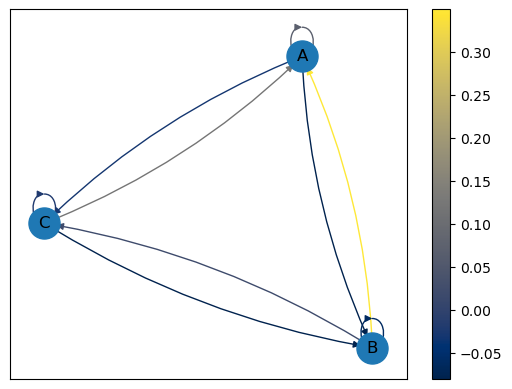

In [29]:
def plot_graph(adj_matrix, labels=None):
    G = nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph) 
    pos = nx.spring_layout(G)


    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('cividis'), node_size=500)

    # Avoid edges id values is 0
    edges = [(i, j) for i, j in G.edges if adj_matrix[i, j] != 0]

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=edges, arrows=True, connectionstyle='arc3, rad = 0.1',
                           edge_cmap=plt.get_cmap('cividis'), edge_color=adj_matrix.flatten()[np.flatnonzero(adj_matrix)])#edge_color=adj_matrix.flatten()[np.flatnonzero(adj_matrix)])


    # Draw node labels
    if labels is not None:
        nx.draw_networkx_labels(G, pos, labels=labels)


    # Add legend for edge colors
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('cividis'))
    sm.set_array(adj_matrix.flatten())
    plt.colorbar(sm)

    plt.show()
print(attention_coefficients)
plot_graph((np.round(attention_coefficients.detach().numpy(),2))[0], labels={0: 'A', 1: 'B', 2: 'C'})

### Write the code for the Graph Attention Layer (2 Points)

Now finalize the architecture by implementing the `GraphAttentionLayer` class.


In [30]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features=3, out_features=128, dropout=0.1, alpha=0.1, heads=4, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha
        self.heads = heads
        self.concat = concat

        if concat: # concatenating the attention heads
            assert out_features % self.heads == 0 # Ensure that out_features is a multiple of n_heads
            self.n_hidden = out_features // self.heads
        else: # averaging output over the attention heads (original)
            self.n_hidden = out_features

        self.W = nn.Parameter(torch.empty(size=(in_features, self.n_hidden * heads)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(heads, 2*self.n_hidden, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.softmax = nn.Softmax(dim=1)

        self.attention = RawAttentionScores(out_features, dropout, alpha,
                                         n_heads=self.heads, concat=self.concat)


    def forward(self, input, adj_matrix):
        n_nodes = input.shape[0]

        # Calculate out features trough matrix multiplication with einsum
        h = torch.einsum('nc,cd->nd', input, self.W) #shape [in_features, n_hidden]
        h = F.dropout(h, self.dropout, training=self.training)

        print(f"h shape before division into heads: {h.shape}")

        # Divide h into heads
        '''
        Add your code below
        '''
        h = h.view(self.heads, n_nodes, self.n_hidden) # shape [n_heads, n_nodes, n_hidden]

        print(f"h shape after division into heads: {h.shape}")

        # Calculate attention scores using AttentionCoefficients
        '''
        Add your code below
        '''
        attention_coefficients = self.attention(h)

        # Mask attention scores
        mask = -9e15*torch.ones_like(attention_coefficients)
        attention_coefficients = torch.where(adj_matrix > 0, attention_coefficients, mask)

        # Apply softmax
        '''
        Add your code below
        '''
        attention_scores = self.softmax(attention_coefficients)

        # Calculate output features
        h_prime = torch.einsum('hnd,hdo->hno', attention_scores, h)

        # Concatenate heads
        '''
        Add your code below
        '''
        if self.concat:
            h_prime = h_prime.view(n_nodes, self.out_features)


        return h_prime, attention_scores


**Do not modify the code below.**

In [31]:
torch.manual_seed(0)
np.random.seed(0)

in_features = 3
number_of_nodes = 3

input = torch.rand(size=(number_of_nodes, in_features))
adj_matrix = torch.tensor([[0, 1, 1], [1, 1, 0], [0, 1, 0]])

attention = GraphAttentionLayer()

output, attention_scores  = attention(input, adj_matrix)

print('Output:\n ', output.shape)

h shape before division into heads: torch.Size([3, 128])
h shape after division into heads: torch.Size([4, 3, 32])
Output:
  torch.Size([3, 128])


Attention Scores:
  tensor([[0.0000, 0.2743, 1.0000],
        [1.0000, 0.4502, 0.0000],
        [0.0000, 0.2755, 0.0000]], grad_fn=<SelectBackward0>)


/var/folders/jb/ntxm50wx2wv90pnq36yd8w940000gn/T/ipykernel_8213/1405077713.py:12: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=edges, arrows=True, connectionstyle='arc3, rad = 0.1',
/var/folders/jb/ntxm50wx2wv90pnq36yd8w940000gn/T/ipykernel_8213/1405077713.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


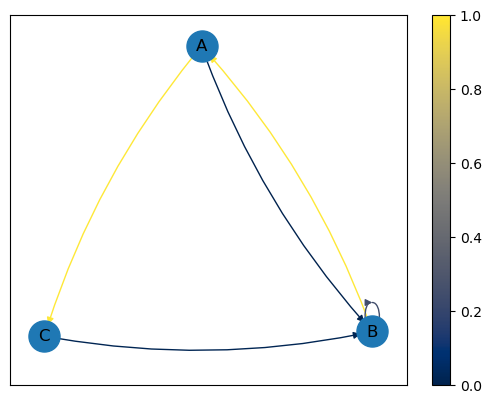

Attention Scores:
  tensor([[0.0000, 0.3442, 1.0000],
        [1.0000, 0.3278, 0.0000],
        [0.0000, 0.3279, 0.0000]], grad_fn=<SelectBackward0>)


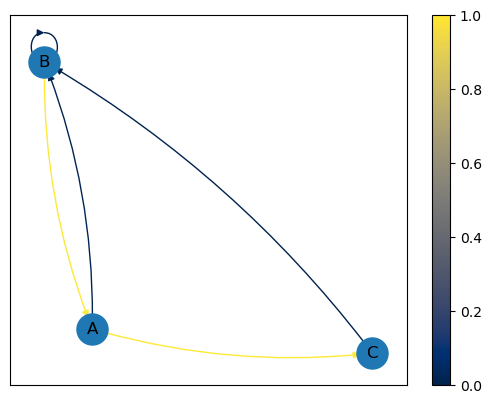

Attention Scores:
  tensor([[0.0000, 0.2649, 1.0000],
        [1.0000, 0.2956, 0.0000],
        [0.0000, 0.4395, 0.0000]], grad_fn=<SelectBackward0>)


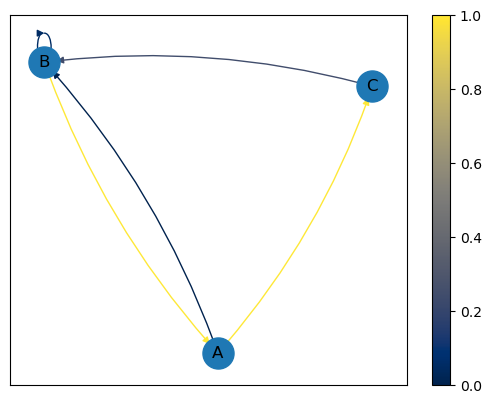

Attention Scores:
  tensor([[0.0000, 0.3341, 1.0000],
        [1.0000, 0.3249, 0.0000],
        [0.0000, 0.3411, 0.0000]], grad_fn=<SelectBackward0>)


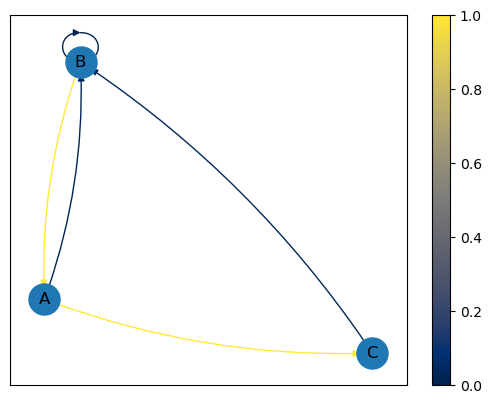

In [32]:
for i in range(attention_scores.shape[0]):
    print('Attention Scores:\n ', attention_scores[i])
    plot_graph((np.round(attention_scores.detach().numpy(),2))[i], labels={0: 'A', 1: 'B', 2: 'C'})

### Encoder-Decoder Block

Same as the Transformer, the GAT also uses the Encoder-Decoder architecture.
**Do not modify the code below.**

In [33]:
class Encoder(nn.Module):
    def __init__(self,
        in_features=3,
        out_features=128,
        n_heads=4,
        concat=True,
        dropout=0.1,
        leaky_relu_slope=0.2):

        super(Encoder, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_heads = n_heads
        self.concat = concat
        self.dropout = dropout
        self.leaky_relu_slope = leaky_relu_slope

        self.encoder = GraphAttentionLayer(in_features, out_features, dropout,
                                           leaky_relu_slope, n_heads, concat)

    def forward(self, input, adj_matrix):
        output, _ = self.encoder(input, adj_matrix)
        return F.elu(output)

In [34]:
class Decoder(nn.Module):
    def __init__(self,
        in_features=3,
        out_features=128,
        n_heads=4,
        concat=True,
        dropout=0.1,
        leaky_relu_slope=0.2):

        super(Decoder, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_heads = n_heads
        self.concat = concat
        self.dropout = dropout
        self.leaky_relu_slope = leaky_relu_slope

        self.decoder = GraphAttentionLayer(in_features, out_features, dropout,
                                           leaky_relu_slope, n_heads, concat)

    def forward(self, input, adj_matrix):
        output, _ = self.decoder(input, adj_matrix)
        return output


### GAT Model (**1 Point**)

Finally we can implement `GAT` model utilizing all of the classes built above.
You will have to carefully read the code below to understand how the model is built, and instiantiate the `Encoder` and `Decoder` with the correct parameters.

In [35]:
class GAT(nn.Module):
    def __init__(self,
        in_features=3,
        n_hidden=128,
        n_heads=4,
        concat=True,
        dropout=0.1,
        leaky_relu_slope=0.2):

        super(GAT, self).__init__()
        self.in_features = in_features
        self.n_hidden = n_hidden
        self.n_heads = n_heads
        self.concat = concat
        self.dropout = dropout
        self.leaky_relu_slope = leaky_relu_slope

        # Define encoder and decoder classes with the missing parameters
        '''
        Modify your code here
        '''
        # Note: the encoder uses multi-head attention, while the decoder uses single-head attention
        self.encoder = Encoder(
            in_features=self.in_features, 
            out_features=self.n_hidden, 
            n_heads=n_heads, 
            concat=concat, 
            dropout=dropout, 
            leaky_relu_slope=leaky_relu_slope)
        
        
        self.decoder = Decoder(
            in_features=self.n_hidden,
            out_features=self.in_features, 
            n_heads=1,
            concat=False, 
            dropout=dropout, 
            leaky_relu_slope=leaky_relu_slope)

    def forward(self, input: torch.Tensor, adj_matrix: torch.Tensor):
        output = self.encoder(input, adj_matrix)
        
        print(f"Input shape is: {input.shape}")
        print(f"Encoder output shape is: {output.shape}")

        output = self.decoder(output, adj_matrix)

        print(f"Decoder output shape is: {output.shape}")
        return output

**do not modify the code below.**

In [36]:
torch.manual_seed(0)
np.random.seed(0)

in_features = 3
number_of_nodes = 3

gat = GAT(in_features=in_features, n_hidden=128, n_heads=4,
          concat=True, dropout=0.1, leaky_relu_slope=0.2)

In [40]:
torch.manual_seed(0) #added this line to make the results reproducible

input = torch.rand(size=(number_of_nodes, in_features))
adj_matrix = torch.tensor([[0, 1, 1], [1, 1, 0], [0, 0, 1]])

output = gat(input.float(), adj_matrix.float())
print('Input:\n ', input)
print('Output:\n ', output)

h shape before division into heads: torch.Size([3, 128])
h shape after division into heads: torch.Size([4, 3, 32])
Input shape is: torch.Size([3, 3])
Encoder output shape is: torch.Size([3, 128])
h shape before division into heads: torch.Size([3, 3])
h shape after division into heads: torch.Size([1, 3, 3])
Decoder output shape is: torch.Size([1, 3, 3])
Input:
  tensor([[0.4963, 0.7682, 0.0885],
        [0.1320, 0.3074, 0.6341],
        [0.4901, 0.8964, 0.4556]])
Output:
  tensor([[[ 0.4520,  0.3019, -0.2079],
         [ 0.1387,  0.1117, -0.0887],
         [ 0.3167,  0.1852, -0.1159]]], grad_fn=<ViewBackward0>)
